# State Space Models

_If you want to understand today, you have to search yesterday_ - Pearl Buck


State space models provide a powerful framework for modeling time series data, particularly when the observed data are generated by an underlying system of **hidden states**. 

A fundamental example of a state space model is the **Hidden Markov Model (HMM)**, which represents a system where an unobserved sequence of states follows a **Markov process**, and each state emits observations according to some probability distribution. 

The **Gaussian Mixture Model (GMM)** is a probabilistic method that represents data as a combination of multiple Gaussian distributions, allowing for the estimation of the likelihood of an unknown state.



In [2]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from finds.readers import fred_qd, fred_md, Alfred
from finds.recipes import approximate_factors, remove_outliers
from secret import paths, credentials
VERBOSE = 0
# %matplotlib qt

In [3]:
# Load and pre-process time series from FRED
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # to indicate recession periods in the plots

In [4]:
# FRED-MD
freq = 'M'
df, t = fred_md() if freq == 'M' else fred_qd()
transforms = t['transform']
data = pd.concat([alf.transform(df[col], tcode=transforms[col], freq=freq)
                  for col in df.columns],
                 axis=1)\
         .iloc[1:]   # apply transforms and drop first row
cols = list(data.columns)

# remove outliers and impute using Bai-Ng approach
r = 8   # fix number of factors = 8
data = remove_outliers(data)
data = approximate_factors(data, kmax=r, p=0, verbose=VERBOSE)

FRED-MD vintage: monthly/current.csv


In [5]:
# standardize inputs
X = StandardScaler().fit_transform(data.values)

## Hidden Markov Model

A **Hidden Markov Model (HMM)** is a type of multivariate time series model where the system is governed by a set of **unobserved (hidden) states** that follow a Markov process. The model is characterized by three key components:  

1. **Transition probabilities**: The likelihood of moving from one state to another (or remaining in the same state), represented by a **transition matrix** $ A $.  
2. **Emission probabilities**: The probability of observing a certain value given a hidden state, denoted as $ \theta $.  
3. **Initial state distribution**: A probability vector $ \pi $ that defines the starting state of the system.  

Thus, an HMM is fully specified by the parameter set $ \lambda = (A, \theta, \pi) $. The observed sequence $ X $ is generated by an unobserved state sequence $ Z $, making inference about $ Z $ a central problem in HMM applications.  

To work with HMMs in Python, we use the `hmmlearn` package, which provides efficient algorithms for solving the three fundamental HMM tasks:  

- **Evaluation**: Computing the likelihood of an observation sequence given the model, $ P(X | \lambda) $. This is solved using the **Forward-Backward algorithm**, implemented via the `.score()` method.  
- **Decoding**: Determining the most probable sequence of hidden states $ Z $ given the observations $ X $. This is accomplished using the **Viterbi algorithm**, accessed through the `.predict()` method.  
- **Training**: Estimating the model parameters $ \lambda = (A, \theta, \pi) $ by maximizing the likelihood of the observed data. This is done using the **Baum-Welch algorithm**, a specific case of the **Expectation-Maximization (EM) algorithm**, via the `.fit()` method.  

The `GaussianHMM` model in `hmmlearn` assumes a **Gaussian distribution** for emissions. The `covariance_type` parameter controls the structure of the covariance matrix, with the following options (ordered by increasing complexity):  

- `"spherical"`: A single variance value is used for all features within each state.  
- `"diag"`: Each state has a diagonal covariance matrix, allowing feature-specific variances.  
- `"tied"`: A single full covariance matrix is shared across all states.  
- `"full"`: Each state has its own full covariance matrix, providing the most flexibility.  

To select the optimal model, an **information criterion** such as the **Bayesian Information Criterion (BIC)** can be used to balance model complexity and goodness of fit.  


In [6]:
def hmm_summary(markov, X, lengths, matrix=False):
    """Helper to return summary statistics from fitting Hidden Markov Model

    Args:
        markov: Fitted GaussianHMM 
        X: Input data of shape (nsamples, nfeatures)
        lengths: Lengths of the individual sequences in X, sum is nsamples
        matrix: Whether to return the transition and stationary matrices

    Returns:
        Dictionary of results in {'aic', 'bic', 'parameters', 'NLL'}
    """
    logL = markov.score(X, lengths)
    T = np.sum(lengths)      # n_samples
    n = markov.n_features    # number of features ~ dim of covariance matrix
    m = markov.n_components  # number of states
    k = dict(diag=m*n,       # parms in mean and cov matrix
             full=m*n*(n-1)/2,
             tied=n*(n-1)/2,
             spherical=m)[markov.covariance_type] + markov.n_features   
    p = m**2 + (k * m) - 1   # number of indepedent parameters of the model
    
    results = {'aic': -2 * logL + (2 * p),
               'bic': -2 * logL + (p * np.log(T)),
               'parameters': p,
               'NLL' : -logL}
    if matrix:   # whether to return the transition and stationary matrix
        matrix = DataFrame(markov.transmat_)\
            .rename_axis(columns='Transition Matrix:')
        matrix['Stationary'] = markov.get_stationary_distribution()
        results.update({'matrix': matrix})   # return matrix as DataFrame
    return results

In [7]:
# Compare covariance types in Gaussian HMM models 
out = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    for n_components in range(1, 8):
        if VERBOSE:
            print('=============', covariance_type, n_components, "==========")
        markov = hmm.GaussianHMM(n_components=n_components,
                                 covariance_type=covariance_type,
                                 verbose=VERBOSE,
                                 tol=1e-6,
                                 random_state=0,
                                 n_iter=500)\
                    .fit(X, [X.shape[0]])
        result = hmm_summary(markov, data, [X.shape[0]])
        #print(n_components, Series(results, name=covariance_type).to_frame().T)
        result.update({'cov_type': covariance_type,
                       'n_components': n_components})
        out.append(Series(result))
results = pd.concat(out, axis=1).T.convert_dtypes()

Model is not converging.  Current: -48374.028067592284 is not greater than -48374.02806594439. Delta is -1.6478952602483332e-06
Model is not converging.  Current: -125173.83118863673 is not greater than -125173.83118797389. Delta is -6.628397386521101e-07
Model is not converging.  Current: -123662.93419332648 is not greater than -123662.93417683932. Delta is -1.648715988267213e-05


In [8]:
# Show best bic's
best_bic = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    result = results[results['cov_type'] == covariance_type]
    argmin = np.argmin(result['bic'])
    best_bic.append(result.iloc[[argmin]])
best_bic = pd.concat(best_bic, axis=0)
best_type = best_bic.iloc[np.argmin(best_bic['bic'])]['cov_type']
print(f"HMM best bic type: {best_type}")
best_bic.round(0)

HMM best bic type: spherical


,aic,bic,parameters,NLL,cov_type,n_components
0,212991056.0,213028448.0,8001,106487527.0,full,1
12,16508012.0,16532906.0,5327,8248679.0,diag,6
14,212991056.0,213028448.0,8001,106487527.0,tied,1
23,14544672.0,14546518.0,395,7271941.0,spherical,3


In [9]:
# fit model with best_bic
n_components = best_bic[best_bic['cov_type'] == best_type]['n_components']
n_components = int(n_components.iloc[0])
markov = hmm.GaussianHMM(n_components=n_components, covariance_type=best_type,
                         verbose=False, tol=1e-6, random_state=0, n_iter=100)\
            .fit(X, [X.shape[0]])
pred_markov = Series(markov.predict(X),
                     name='state',
                     index=pd.to_datetime(data.index, format="%Y%m%d"))
matrix = hmm_summary(markov, X, [X.shape[0]], matrix=True)['matrix']

In [10]:
# Compute average change in INDPRO by state
df = alf('INDPRO', freq=freq, log=1, diff=1)
df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
indpro = pd.concat([df, pred_markov], join='inner', axis=1).groupby('state').mean('INDPRO')

# and HMM transition and stationary probabilities
print("HMM transition and stationary probabilities, and average INDPRO value by state")
matrix.join(indpro).round(4)

HMM transition and stationary probabilities, and average INDPRO value by state


,0,1,2,Stationary,INDPRO
0,0.6485,0.1775,0.1740,0.1720,-0.0020
1,0.0677,0.8595,0.0728,0.4482,0.0053
2,0.0793,0.0854,0.8352,0.3798,-0.0002


__Plot predicted states__

In [11]:
def plot_states(modelname, labels, num=1, series_id='INDPRO', freq='M'):
    """helper to plot predicted states 'IPMANSICS'"""

    # n_components markers
    n_components = len(np.unique(labels))
    markers = ["o", "s", "d", "X", "P", "8", "H", "*", "x", "+"][:n_components] 
    
    fig, (bx, ax) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

    # plot series, with states colored
    df = alf(series_id, freq=freq)
    df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
    df = df[(df.index >= min(labels.index)) & (df.index <= max(labels.index))]
    for i, marker in zip(range(n_components), markers):
        df.loc[labels == i].plot(ax=ax, style=marker, markersize=2, color=f"C{i}", rot=0)
    ax.set_xlabel(f"{series_id}: {alf.header(series_id)}")
    ax.set_xlim(left=min(df.index), right=max(df.index))
    for a,b in vspans:   # shade economic recession periods
        if (b > min(df.index)) & (a < max(df.index)):
            ax.axvspan(max(a, min(df.index)), min(b, max(df.index)),
                       alpha=0.3, color='grey')
    ax.legend([f"state {i}" for i in range(n_components)], fontsize=8)
    ax.set_yscale('log')

    s = np.zeros((n_components, len(labels)))
    for i, j in enumerate(labels.values.flatten()):
        s[j][i] = j + 1
    sns.heatmap(s, vmin=0, vmax=n_components, ax=bx, cbar=False, xticklabels=False,
                cmap=["lightgrey"] + [f"C{i}" for i in range(n_components)])
    bx.set_xlabel('predicted state')
    date_str = f" ({str(df.index[0])[:7]} to {str(df.index[-1])[:7]})"
    fig.suptitle(f"{modelname.upper()} Predicted States" + date_str)

    plt.tight_layout()

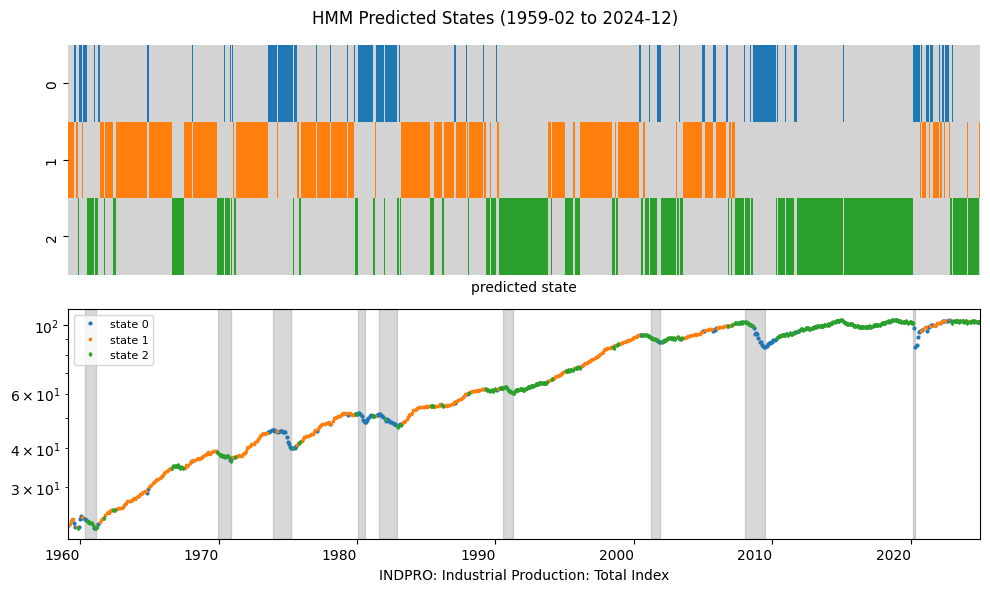

In [12]:
plot_states('HMM', pred_markov, num=1, freq=freq)

### Markov Chains

Markov Chains are a fundamental class of state space models where the future state of a system depends only on the current state and not on past states. Key concepts in Markov Chains include:  

- Geometric Runs: The probability distribution of the time until a particular state recurs, which often follows a geometric distribution.  
- Irreducibility: A property of a Markov Chain where it is possible to reach any state from any other state, ensuring long-run stability in the system.  

The `Graphviz` python package can be used to visualize the states and transition probabilities of a Hidden Markov Model (HMM), providing a representation of how states evolve over time.

In [13]:
# Visualize HMM transitions and states
from sklearn.preprocessing import minmax_scale
colors = minmax_scale(indpro).flatten()

import graphviz
def fillcolor(r, g, b):
    def scale(x):
        return int((1 - x) * 256 * .5 + 64)
    return f"#{scale(r):02x}{scale(g):02x}{scale(b):02x}"

In [14]:
dot = graphviz.Digraph(engine='circo', graph_attr={'splines': 'true'})
dot.graph_attr['size'] = '10,10'  
dot.graph_attr['ratio'] = 'expand'
for i in range(len(matrix)):  # Add nodes
    dot.node(name=str(i), label=f"{matrix.iloc[i, i]:.03f}",
             style='filled', fillcolor=fillcolor(0, colors[i], colors[i]))
for i in range(len(matrix)):  # Add edges
    for j in range(len(matrix)):
        if i != j:
            dot.edge(tail_name=str(i), head_name=str(j),
                     label=f"{matrix.iloc[i, j]:.03f}", color='red')


In [15]:
matrix

Transition Matrix:,0,1,2,Stationary
0,0.648460,0.177506,0.174035,0.171962
1,0.067656,0.859514,0.072830,0.448240
2,0.079320,0.085432,0.835248,0.379799


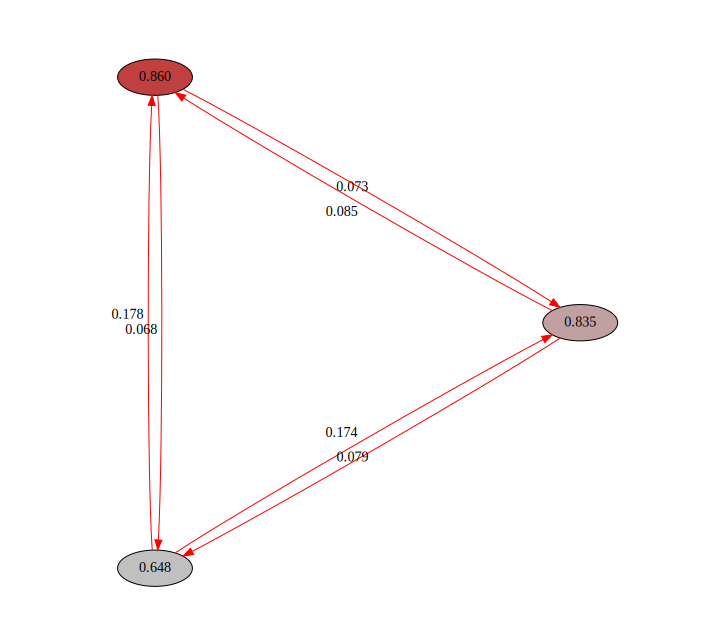

In [16]:
dot
# dot.format = 'png'
# dot.view(filename='digraph')  # Visualize the graph

## Gaussian Mixture Model

A **Gaussian Mixture Model (GMM)** is a probabilistic model that assumes that the data is generated from a mixture of multiple Gaussian distributions. Each component in the mixture represents a different subpopulation within the data. The following are tje parameters that need to be estimated:  

1. Mixing Coefficients (Weights) $\pi_k$ – These represent the proportion of each Gaussian component in the overall mixture and must sum to 1.  

2. Mean Vectors $\mu_k$ – The center of each Gaussian component in the feature space, indicating where each cluster is located.  

3. Covariance Matrices $\Sigma_k$ – These define the shape and spread of each Gaussian distribution, determining how data points are dispersed around the mean.  

These parameters are typically estimated using the **Expectation-Maximization (EM) algorithm**, by iteratively optimizing the likelihood of the observed data.  

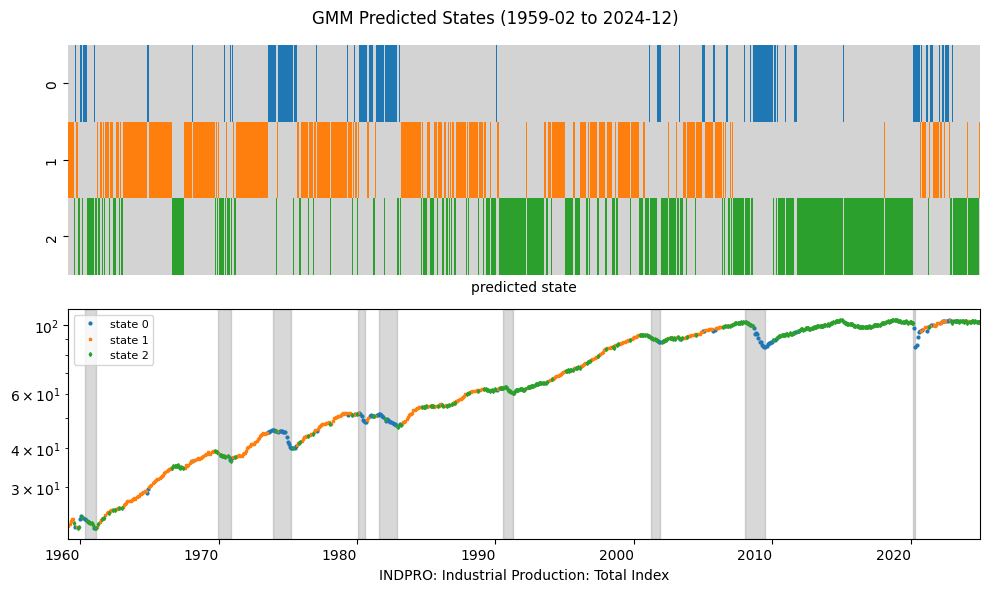

In [17]:
gmm = GaussianMixture(n_components=n_components,
                      random_state=0,
                      covariance_type=best_type).fit(X)
pred_gmm = Series(gmm.predict(X),
                  name='state',
                  index=pd.to_datetime(data.index, format="%Y%m%d"))
plot_states('GMM', pred_gmm, num=2, freq=freq)

### Persistance

Persistence in an HMM refers to the likelihood that the system remains in the same hidden state over time rather than transitioning to a different state. It is determined by the self-transition probabilities on the diagonal of the transition matrix.

In GMMs, persistence refers to the likelihood of a data point belonging to the same Gaussian component across different observations. Since GMMs do not model temporal dependencies like HMMs, persistence is inferred from the posterior probability of a point belonging a particular cluster.




In [18]:
# Compare persistance of HMM and GMM
dist = DataFrame({
    'Hidden Markov': ([np.mean(pred_markov[:-1].values == pred_markov[1:].values)]
                      + matrix.iloc[:,-1].tolist()),
    'Gaussian Mixture': ([np.mean(pred_gmm[:-1].values == pred_gmm[1:].values)]
                         + (pred_gmm.value_counts().sort_index()/len(pred_gmm)).tolist())},
                 index=(['Average persistance of states']
                        + [f'Stationary prob of state {s}' for s in range(n_components)]))
print("Compare HMM with GMM:")
dist

Compare HMM with GMM:


,Hidden Markov,Gaussian Mixture
Average persistance of states,0.820253,0.732911
Stationary prob of state 0,0.171962,0.152971
Stationary prob of state 1,0.448240,0.424779
Stationary prob of state 2,0.379799,0.422250
